<a href="https://colab.research.google.com/github/y-oth/dst_Assessment0/blob/master/01%20-%20SGD%20vs%20DP-SGD%20on%20Fashion-MNIST/DP_CNN_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question 11.2 : Differential Privacy SGD


We extend the workshop ([Workshop 7.3](https://github.com/dsbristol/dst/blob/master/assets/workshops/block07-DSToolboxWeek7NNLab.ipynb)) to investigate differential privacy and the Algorithm suggested in the Deep Learning for Differential Privacy paper.

Import Libraries

In [ ]:
# Import PyTorch
import torch
# Setup device agnostic code
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print("Device (should be 'cuda' if you changed the runtime):", device)
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

Device (should be 'cuda' if you changed the runtime): cuda
PyTorch version: 2.9.0+cu126
torchvision version: 0.24.0+cu126


# Data Setup

We are going to use the [FashionMNIST dataset](https://arxiv.org/abs/1708.07747) which is a commonly used benchmarking dataset of images of different items of clothing. PyTorch lets us import them directly but often in applications you will need to load data in - this can be a faff with larger image datasets, language datasets and especially video datasets. FashionMNIST is by default seperated into a train set and test set.

In [ ]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 187kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.48MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.2MB/s]


In [ ]:
# See classes
class_names = train_data.classes
print(class_names)
print("Output size:", len(class_names))

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Output size: 10


In [ ]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7e4f1ba7da00>, <torch.utils.data.dataloader.DataLoader object at 0x7e4f03794740>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


# Building the CNN from the workshop:

In [ ]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


        self.flatten = nn.Flatten()
        self.fc = nn.Linear(hidden_units * 7 * 7, output_shape)

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=490, out_features=10, bias=True)
)

Training our CNN using the standard Stochastic Gradient Decsent Optimiser.

In [ ]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)

    for batch, (X, y) in enumerate(data_loader):
        # Send data to device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        return test_loss, test_acc

In [ ]:
from tqdm import tqdm
# Measure time
from timeit import default_timer as timer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), # note that we need model_2 parameters here!
                            lr=0.1)

test_loss_list = []
test_acc_list = []
train_loss_list = []
train_acc_list = []

# Measure time; this model took about 10 minutes to train with epochs = 10
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_loss, train_acc = train_step(data_loader=train_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_loss, test_acc = test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    train_loss_list.append(train_loss.item())
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss.item())
    test_acc_list.append(test_acc)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.58005 | Train accuracy: 79.08%


 10%|█         | 1/10 [00:13<02:04, 13.83s/it]

Test loss: 0.39035 | Test accuracy: 85.63%

Epoch: 1
---------
Train loss: 0.35574 | Train accuracy: 87.18%


 20%|██        | 2/10 [00:25<01:42, 12.85s/it]

Test loss: 0.36478 | Test accuracy: 86.19%

Epoch: 2
---------
Train loss: 0.31699 | Train accuracy: 88.50%


 30%|███       | 3/10 [00:38<01:27, 12.51s/it]

Test loss: 0.32271 | Test accuracy: 88.42%

Epoch: 3
---------
Train loss: 0.29533 | Train accuracy: 89.20%


 40%|████      | 4/10 [00:50<01:14, 12.42s/it]

Test loss: 0.30692 | Test accuracy: 88.69%

Epoch: 4
---------
Train loss: 0.28153 | Train accuracy: 89.75%


 50%|█████     | 5/10 [01:02<01:01, 12.38s/it]

Test loss: 0.30325 | Test accuracy: 88.92%

Epoch: 5
---------
Train loss: 0.27074 | Train accuracy: 90.14%


 60%|██████    | 6/10 [01:14<00:49, 12.27s/it]

Test loss: 0.28519 | Test accuracy: 89.60%

Epoch: 6
---------
Train loss: 0.26231 | Train accuracy: 90.42%


 70%|███████   | 7/10 [01:26<00:36, 12.18s/it]

Test loss: 0.30933 | Test accuracy: 88.53%

Epoch: 7
---------
Train loss: 0.25445 | Train accuracy: 90.66%


 80%|████████  | 8/10 [01:38<00:24, 12.08s/it]

Test loss: 0.29736 | Test accuracy: 89.42%

Epoch: 8
---------
Train loss: 0.25219 | Train accuracy: 90.89%


 90%|█████████ | 9/10 [01:50<00:12, 12.07s/it]

Test loss: 0.28098 | Test accuracy: 89.74%

Epoch: 9
---------
Train loss: 0.24674 | Train accuracy: 90.92%


100%|██████████| 10/10 [02:02<00:00, 12.28s/it]

Test loss: 0.29564 | Test accuracy: 89.10%

Train time on cuda: 122.813 seconds


# Extending our CNN to use DP-SGD:
In order to do this we import the [Opacus package](https://opacus.ai/api/optim/dp_optimizer.html) which hosts the DP-SGD optimser using the exact same algorithm as in Algorithm 1 in the [Deep Learning for Differential Privacy Paper](https://dl.acm.org/doi/abs/10.1145/2976749.2978318?casa_token=Kboqf1oQ2LoAAAAA:rdlgBTUeFvzX7fdqHv9vu3GR9kW0vsMOWzgbqniLQXuGF-XmK3Lf93URi_0lF7KBV4T6201_ca3F_).


In [ ]:
!pip -q install opacus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.4/254.4 kB 15.7 MB/s eta 0:00:00


We now re-run the CNN model with the DP-SGD optmiser and check it's accuracy

In [ ]:
model_2 = FashionMNISTModelV2(1, 10, len(class_names)).to(device)
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()


Using `make_private` from the `opcaus` library we make the SGD optimiser private. Converting it into the DP-SGD. We can also control what to set our noise $\sigma$ and clipping bound $C$ to as shown below.

In [ ]:
from opacus import PrivacyEngine

privacy_engine = PrivacyEngine()

model_2.train()

model_2, optimizer, train_dataloader = privacy_engine.make_private(
    module=model_2,
    optimizer=optimizer,
    data_loader=train_dataloader,
    noise_multiplier=1.1,   # how much noise to add (σ)
    max_grad_norm=1.0,      # gradient clipping bound C
)


/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


In [ ]:
def train_dp(model, train_loader, optimizer, loss_fn, accuracy_fn, device):
    model.train()
    total_loss = 0.0
    total_acc = 0.0

    for X, y in train_loader:
        if X.nelement() == 0:   # <-- IMPORTANT FIX
            continue

        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        preds = model(X)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            total_loss += loss.item()
            total_acc  += accuracy_fn(y, preds.argmax(1))

    return total_loss / len(train_loader), total_acc / len(train_loader)


In [ ]:
def test_dp(model, test_loader, loss_fn, accuracy_fn, device):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0

    with torch.inference_mode():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            total_loss += loss_fn(preds, y).item()
            total_acc  += accuracy_fn(y, preds.argmax(1))

    return total_loss / len(test_loader), total_acc / len(test_loader)


## Tracking Privacy Loss:

Checking which 'privacy accountant' we are using, i.e. what method we are using to track our privacy loss.

In [ ]:
print(privacy_engine.accountant.__class__.__name__)


PRVAccountant


The `get_epsilon` function computes the total privacy loss by querying the 'privacy accountant', which tracks DP-SGD leakage using the Privacy Random Variable (PRV) method.

The PRV Accountant tracks privacy loss by modeling each DP-SGD update as a privacy random variable and composing these distributions across training steps, producing a tighter (lower) ε than other accounting methods.

 Its computation follows four main steps:

1. Defines privacy loss per step as a random variable  
   Each DP-SGD update produces a privacy-loss random variable $L_t$, capturing how distinguishable two neighbouring datasets are after that step.

2. Computes the distribution of this random variable for DP-SGD  
   For a given sampling rate $q$ and noise multiplier $\sigma$, PRV analytically determines the distribution of $L_t$.

3. Accumulates privacy across training by adding distributions  
   Since privacy loss composes additively, the total privacy loss is  
   $$
   L_{\text{total}} = \sum_{t=1}^T L_t.
   $$

4. Computes the final privacy guarantee by bounding the tail probability  
   PRV finds the smallest value of $\varepsilon$ such that  
   $$
   \Pr(L_{\text{total}} > \varepsilon) \le \delta.
   $$

Because PRV works with full distributions of privacy loss rather than loose analytical bounds, it produces tighter and more accurate values of $\varepsilon$ than traditional RDP composition. [[1](https://github.com/microsoft/prv_accountant/tree/main)], [[2](https://github.com/meta-pytorch/opacus/blob/main/opacus/accountants/prv.py)], [[3](https://arxiv.org/abs/2106.02848)]


### Training

In [ ]:
epochs = 10

DPtest_loss_list = []
DPtest_acc_list = []
DPtrain_loss_list = []
DPtrain_acc_list = []
epsilon_list = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch}\n---------")

    train_loss_dp, train_acc_dp = train_dp(
        model_2, train_dataloader, optimizer,
        loss_fn, accuracy_fn, device
    )

    test_loss_dp, test_acc_dp = test_dp(
        model_2, test_dataloader,
        loss_fn, accuracy_fn, device
    )

    epsilon = privacy_engine.get_epsilon(delta=1e-5)

    print(f"Train Loss: {train_loss_dp:.4f} | Acc: {train_acc_dp:.2f}%")
    print(f"Test Loss:  {test_loss_dp:.4f} | Acc: {test_acc_dp:.2f}%")
    print(f"ε = {epsilon:.2f}, δ = 1e-5")

    DPtrain_loss_list.append(train_loss_dp)
    DPtrain_acc_list.append(train_acc_dp)
    DPtest_loss_list.append(test_loss_dp)
    DPtest_acc_list.append(test_acc_dp)
    epsilon_list.append(epsilon)

sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.



Epoch 0
---------
Train Loss: 1.4525 | Acc: 64.73%
Test Loss:  1.5193 | Acc: 71.93%
ε = 0.09, δ = 1e-5

Epoch 1
---------
Train Loss: 1.6140 | Acc: 73.05%
Test Loss:  1.7045 | Acc: 72.33%
ε = 0.13, δ = 1e-5

Epoch 2
---------
Train Loss: 1.5454 | Acc: 73.70%
Test Loss:  1.9920 | Acc: 73.41%
ε = 0.16, δ = 1e-5

Epoch 3
---------
Train Loss: 1.7312 | Acc: 73.88%
Test Loss:  2.0464 | Acc: 72.83%
ε = 0.18, δ = 1e-5

Epoch 4
---------
Train Loss: 1.8094 | Acc: 73.43%
Test Loss:  1.8404 | Acc: 72.52%
ε = 0.21, δ = 1e-5

Epoch 5
---------
Train Loss: 1.9349 | Acc: 73.41%
Test Loss:  2.1042 | Acc: 72.40%
ε = 0.23, δ = 1e-5

Epoch 6
---------
Train Loss: 1.8507 | Acc: 73.59%
Test Loss:  1.8603 | Acc: 72.68%
ε = 0.24, δ = 1e-5

Epoch 7
---------
Train Loss: 1.8411 | Acc: 74.03%
Test Loss:  2.1355 | Acc: 71.88%
ε = 0.26, δ = 1e-5

Epoch 8
---------
Train Loss: 1.7641 | Acc: 73.99%
Test Loss:  1.6902 | Acc: 73.53%
ε = 0.28, δ = 1e-5

Epoch 9
---------
Train Loss: 1.6744 | Acc: 74.21%
Test Loss:  

The privacy loss here is the final ε, δ pair after training finishes.

From the output we see that, ε is cumulative and increases each epoch:

- After epoch 0: $ε = 0.09$  
- …  
- After epoch 9: $ε = 0.29$, with $δ = 1e^{-5}$

So the trained model at the end of 10 epochs satisfies:

$(\epsilon = 0.29, \delta = 10^{-5})$-differential privacy

That means:

- Changing or removing any single person’s data can change the distribution of the model’s outputs by at most a factor of $e^{0.29} \approx 1.34$, except with probability at most $10^{-5}$.
- This is very strong privacy.


## Train Loss Comparison

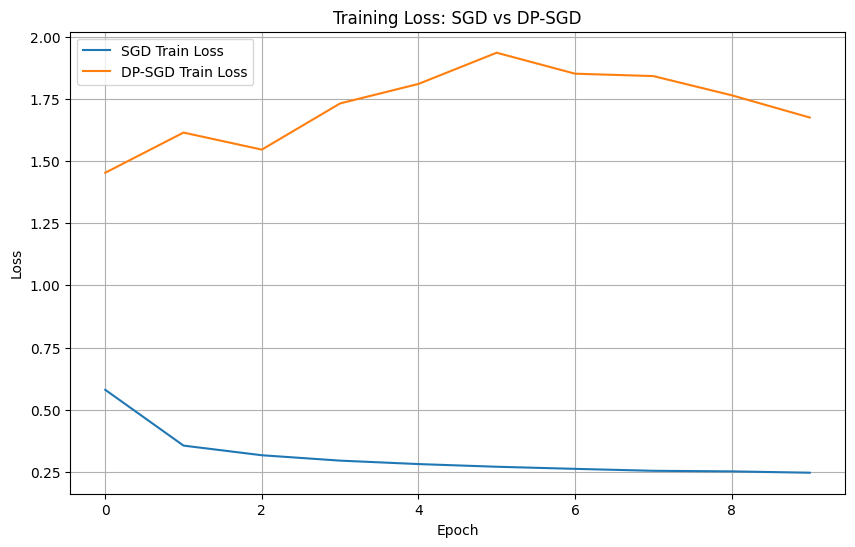

In [ ]:
#Train - Loss Comparison:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label="SGD Train Loss")
plt.plot(DPtrain_loss_list, label="DP-SGD Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss: SGD vs DP-SGD")
plt.legend()
plt.grid(True)
plt.show()


## Test Loss Comparison

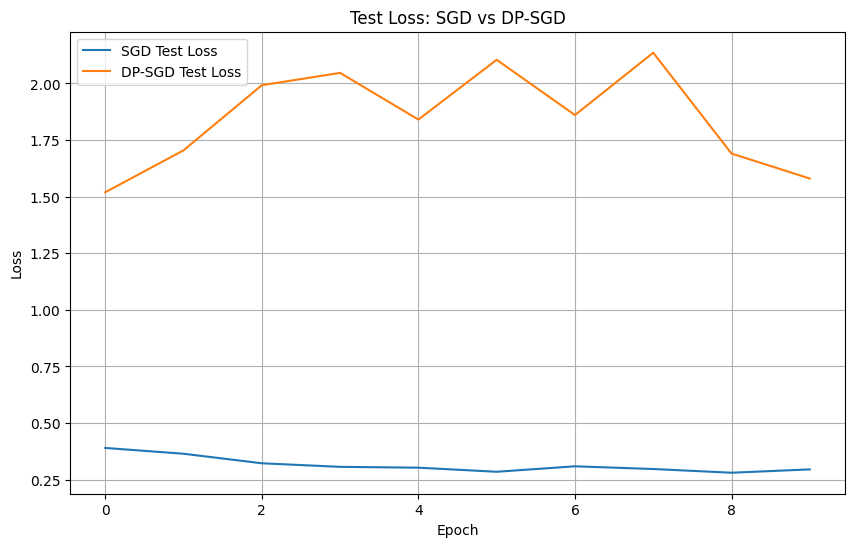

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_loss_list, label="SGD Test Loss")
plt.plot(DPtest_loss_list, label="DP-SGD Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Test Loss: SGD vs DP-SGD")
plt.legend()
plt.grid(True)
plt.show()


## Train Accuracy Comparison

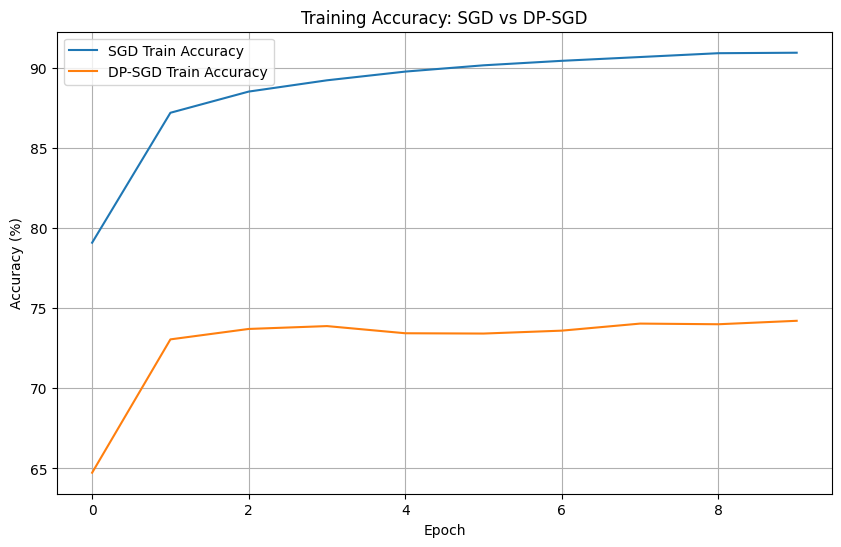

In [ ]:
# Train accuracy comparison
plt.figure(figsize=(10, 6))
plt.plot(train_acc_list, label="SGD Train Accuracy")
plt.plot(DPtrain_acc_list, label="DP-SGD Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy: SGD vs DP-SGD")
plt.legend()
plt.grid(True)
plt.show()


# Privacy Budget ϵ over training

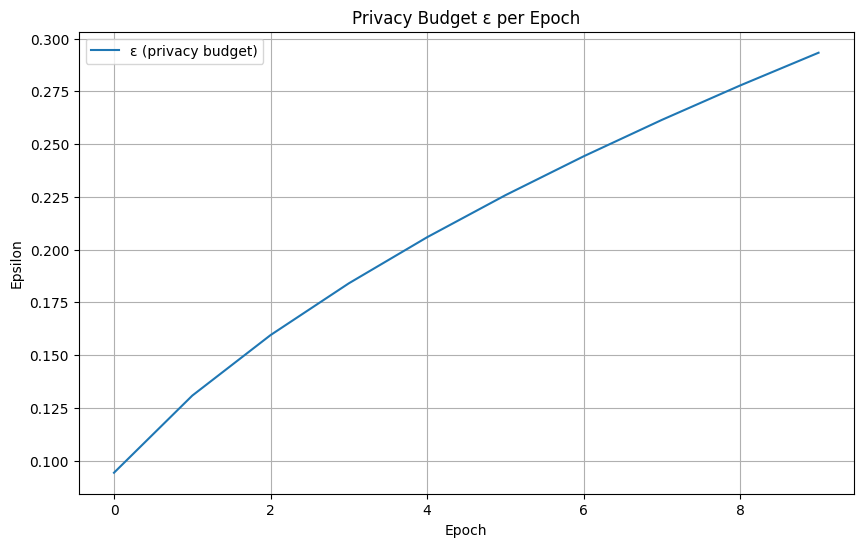

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epsilon_list, label="ε (privacy budget)")
plt.xlabel("Epoch")
plt.ylabel("Epsilon")
plt.title("Privacy Budget ε per Epoch")
plt.legend()
plt.grid(True)
plt.show()


## Privacy - Utility Trade Off Plot

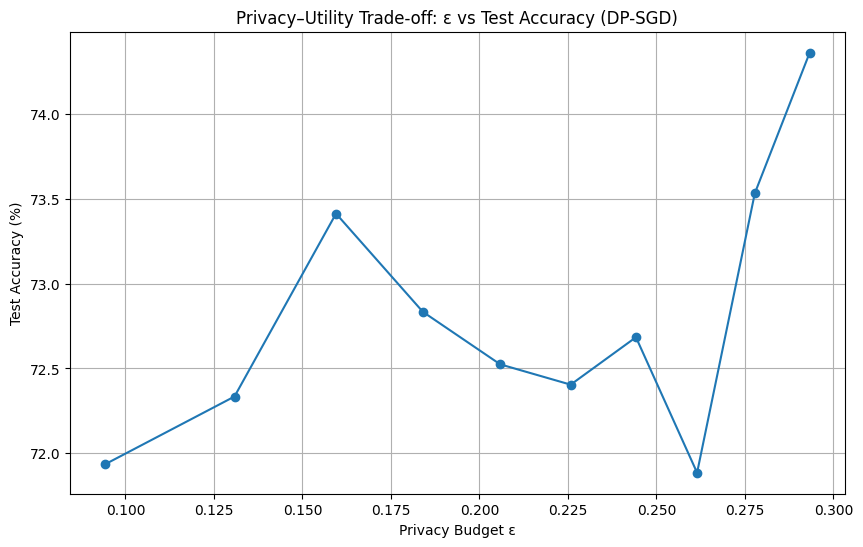

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(epsilon_list, DPtest_acc_list, marker='o')
plt.xlabel("Privacy Budget ε")
plt.ylabel("Test Accuracy (%)")
plt.title("Privacy–Utility Trade-off: ε vs Test Accuracy (DP-SGD)")
plt.grid(True)
plt.show()


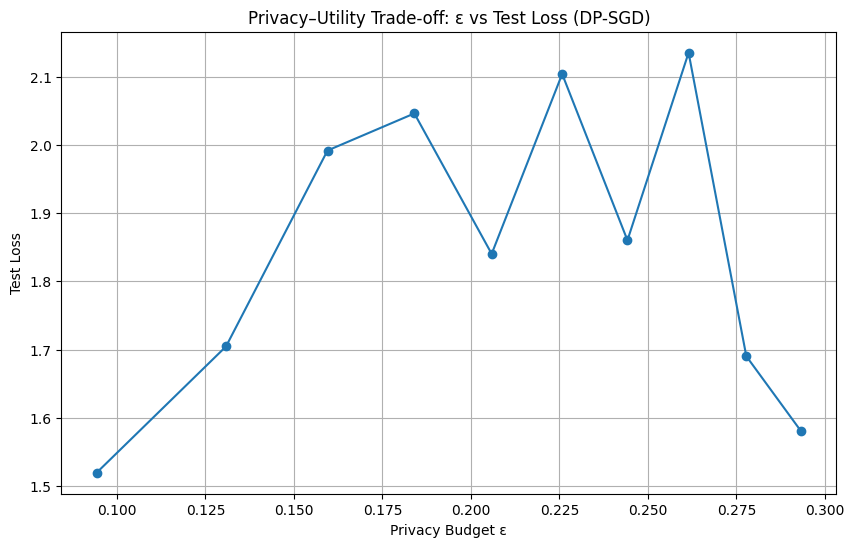

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(epsilon_list, DPtest_loss_list, marker='o')
plt.xlabel("Privacy Budget ε")
plt.ylabel("Test Loss")
plt.title("Privacy–Utility Trade-off: ε vs Test Loss (DP-SGD)")
plt.grid(True)
plt.show()


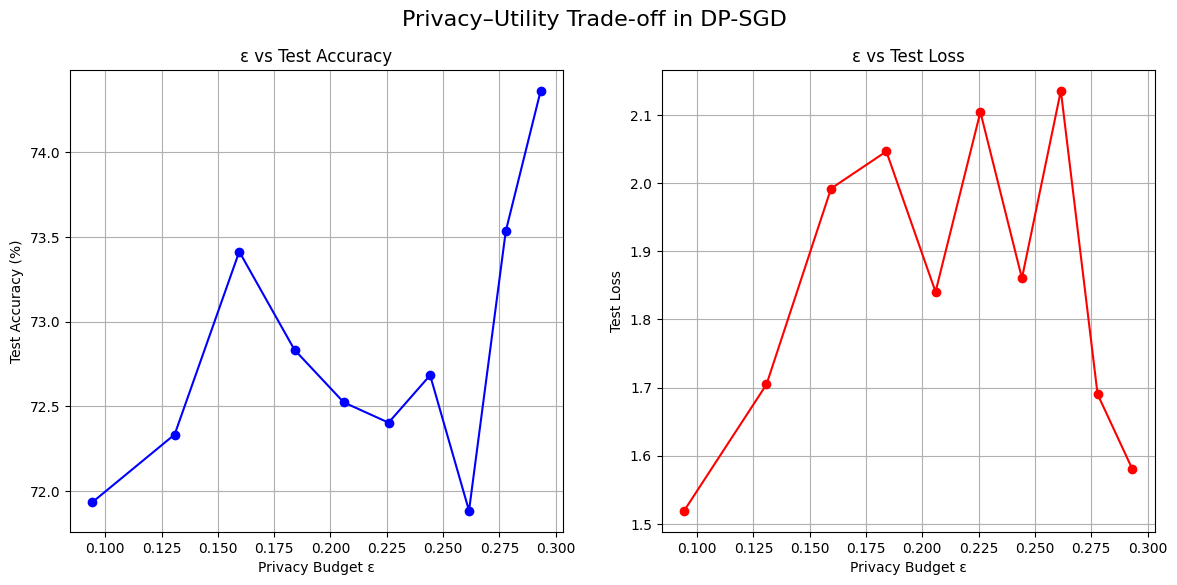

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

# ε vs accuracy
ax[0].plot(epsilon_list, DPtest_acc_list, marker='o', color="blue")
ax[0].set_xlabel("Privacy Budget ε")
ax[0].set_ylabel("Test Accuracy (%)")
ax[0].set_title("ε vs Test Accuracy")
ax[0].grid(True)

# ε vs loss
ax[1].plot(epsilon_list, DPtest_loss_list, marker='o', color="red")
ax[1].set_xlabel("Privacy Budget ε")
ax[1].set_ylabel("Test Loss")
ax[1].set_title("ε vs Test Loss")
ax[1].grid(True)

plt.suptitle("Privacy–Utility Trade-off in DP-SGD", fontsize=16)
plt.show()


Plots show a clear increase in test accuracy when we relax the privacy restrictions. Allowing the privacy budget to increase indefinitely converges the test-accuracy towards that of the standard SGD.